<a href="https://colab.research.google.com/github/ni-lie/CS138-Capstone/blob/main/CS138_project_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Team Kill Counts at the 15th Minute in Dota 2 Captain's Mode: A Linear Regression Approach with Gradient Descent Optimization

# Import libraries



In [1]:
!pip install ratelimiter

In [2]:
import requests
import pandas as pd
import numpy as np
import random

from ratelimiter import RateLimiter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generating the Training Dataset from OpenDota

In [ ]:
@RateLimiter(max_calls=1, period=1)
def getMatchIds():
  url = f"https://api.opendota.com/api/explorer?sql=SELECT matches.match_id FROM matches JOIN match_patch using(match_id) JOIN player_matches using(match_id) WHERE TRUE AND match_patch.patch >= '7.34' AND match_patch.patch <= '7.34' AND matches.duration >= 900 AND game_mode = 2 ORDER BY RANDOM() LIMIT 50"
  response = requests.get(url)
  print(response.status_code)
  if response.status_code == 200:
    match_ids = [x['match_id'] for x in response.json()['rows']]
    return match_ids
  else: return []

In [ ]:
@RateLimiter(max_calls=1, period=1)
def get_responses(match_ids):
  # create a list of responses where we will append each request
  responses = []

  for match_id in match_ids:
    # Define the API endpoint
    url = f'https://api.opendota.com/api/matches/{match_id}?'

    # append response
    responses.append(requests.get(url))

  return responses

In [ ]:
def extract_features(responses):
  rows = []

  for index, response in enumerate(responses):
  # Check if the request was successful
    if response.status_code == 200:
      # Parse the JSON response
      data = response.json()

      try:
        # initialize team array: gpm, xpm, kpm, won
        team1 = [0, 0, 0]
        team2 = [0, 0, 0]

        for player in data['players']:
          # Fetch the GPM, XPM, and KPM at the 15th minute

          gpm = player['gold_t'][15] / 15       # Get Player's total Gold at 15th minute and divide by 15 para maging GPM
          xpm = player['xp_t'][15] / 15
          kills = len([kill for kill in player['kills_log'] if kill['time'] < (15*60)])

          # Get team's accumulated gpm, xpm, kpm
          if player['isRadiant']:
            team1[0] += gpm
            team1[1] += xpm
            team1[2] += kills

          else:
            team2[0] += gpm
            team2[1] += xpm
            team2[2] += kills


        for i in range(2):
          team1[i] /= 5
          team2[i] /= 5

        # Append the team data to the DataFrame
        rows.append({'bias': 1, 'gold_per_min': team1[0], 'exp_per_min': team1[1], 'kills': team1[2]})
        rows.append({'bias': 1, 'gold_per_min': team2[0], 'exp_per_min': team2[1], 'kills': team2[2]})
      except:
        continue
    else:
        print(f'Error: {response.status_code}')

  # Create a dataframe out of 'rows'
  training_set = pd.concat([pd.DataFrame(rows)], ignore_index=True)
  return training_set

In [ ]:
def extract_dataset():
  match_ids = getMatchIds()
  responses = get_responses(match_ids)
  matches = extract_features(responses)  # get matches with complete data

  # Save the DataFrame to a CSV file
  matches.to_csv('player_data_captain_mode.csv', index=False)

In [ ]:
extract_dataset()

200


# Exploratory Data Analysis

In [31]:
# Load dataset
df = pd.read_csv('player_data_captain_mode.csv')

matches_train, matches_test = train_test_split(df, test_size=0.2, random_state=42)

In [32]:
print(f'total entries: {len(df)}')
print(f'train entries (1 match = 2 entries i.e. Radiant & Dire): {len(matches_train)}')
print(f'test entries (1 match = 2 entries i.e. Radiant & Dire): {len(matches_test)}')

total entries: 4530
train entries (1 match = 2 entries i.e. Radiant & Dire): 3624
test entries (1 match = 2 entries i.e. Radiant & Dire): 906


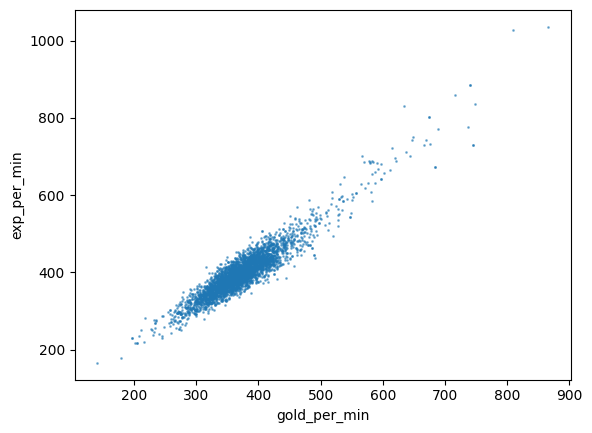

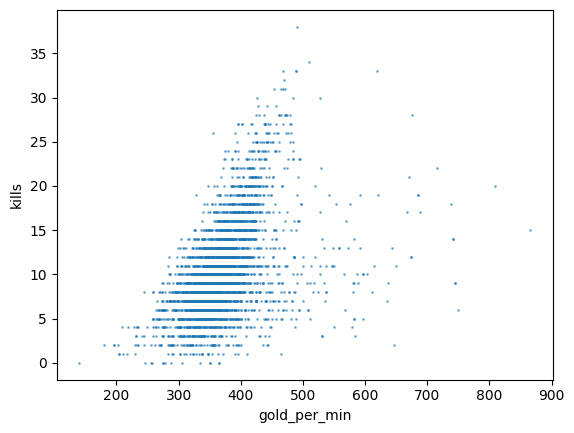

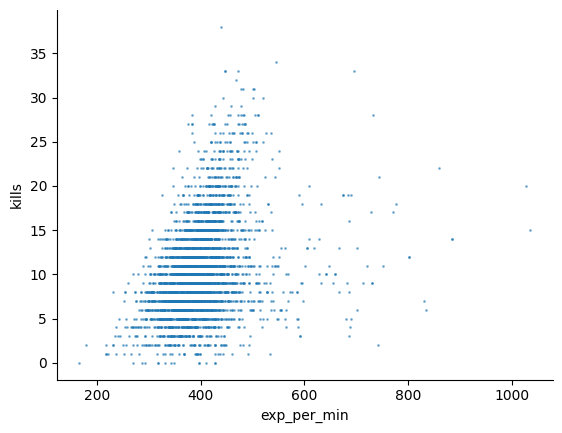

In [5]:
matches_train.plot(kind='scatter', x='gold_per_min', y='exp_per_min', s=1, alpha=.5)
matches_train.plot(kind='scatter', x='gold_per_min', y='kills', s=1, alpha=.5)
matches_train.plot(kind='scatter', x='exp_per_min', y='kills', s=1, alpha=.5)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Training the Model

In [6]:
# loss = (1/n) * (y - (mx + b)) ** 2 where n is the number of points
def loss(y, y_pred):
    n = len(y)
    s = 0
    for i in range(n):
        s += (y[i] - y_pred[i])**2
    return (1/n)*s

In [7]:
# calculates "w*X+b"
def predicted_y(w, X, b):
    return np.array([w @ x + b for x in X])

In [9]:
# derivative of loss w.r.t weight/slope
# D_m = (-2/n) * np.dot(X.T, (y - y_pred))

def dldw(x, y, y_pred):
    n = len(y)
    s = 0
    for i in range(n):
        s += -x[i] *(y[i] - y_pred[i])
    return (2/n)*s


In [10]:
# derivative of loss w.r.t intercept/bias
# D_b = (-2/n) * np.sum(y - y_pred)
def dldb(y, y_pred):
    n = len(y)
    s = 0
    for i in range(len(y)):
        s += -(y[i] - y_pred[i])
    return (2/n) * s

In [30]:
# X: features (xpm, gpm); y: target value (kpm); w: weight vector = [0, 0]; b: intercept
def descend(X, y, w, b, learning_rate, epochs):
  linear_loss = []
  for i in range(epochs):
    y_pred = predicted_y(w, X, b)

    # update w: weight and b: intercept
    w = w - learning_rate * dldw(X, y, y_pred)  # update weight
    b = b - learning_rate * dldb(y, y_pred)    # update bias

    linear_loss.append(loss(y, y_pred))

  plt.plot(np.arange(1, epochs), linear_loss[1:])
  plt.xlabel("number of epoch")
  plt.ylabel("loss")

  return (w, b)

In [12]:
# Define features and target variable
features = ['gold_per_min', 'exp_per_min']
target = 'kills'

# Initialize theta with an additional element for the bias term
theta = np.zeros(len(features) + 1)

# Normalize features
for feature in features:
    matches_train[feature] = (matches_train[feature] - matches_train[feature].mean()) / matches_train[feature].std()

In [33]:
# Split the dataset into features (X) and target variable (y)
X = matches_train.drop([target, "bias"], axis=1).values
y = matches_train[target].values

In [34]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_transform = sc.fit_transform(X)

In [35]:
# Initialize parameters: w - weight vector; b - intercept
w = np.zeros(2)
b = 0
iterations = 1000

# Initialize Hyperparameter (Learning Rate)
L = 0.01

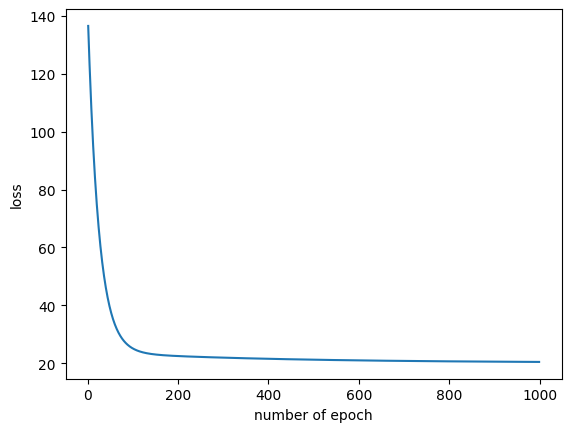

In [36]:
w, b = descend(X_transform, y, w, b, L, iterations)

In [37]:
print(f'weight: {w} \t b: {b}')

weight: [ 5.07205647 -2.80351667] 	 b: 10.604304617914893


# Predicting

In [18]:
def predict(inp, w, b):
  y_list=[]

  for i in range(len(inp)):
    y_list.append(w @ inp[i] + b) # w*X + b
  return np.array(y_list)

In [19]:
# Normalize features
for feature in features:
    matches_test[feature] = (matches_test[feature] - matches_test[feature].mean()) / matches_test[feature].std()

In [20]:
X_test_normalized = matches_test.drop([target, "bias"], axis=1).values
y_test = matches_test[target].values

In [21]:
y_pred_test = predict(X_test_normalized, w, b)
y_pred_test

array([10.41131962, 12.62161581, 12.76205625, 11.70935754, 14.854     ,
       12.92666248, 10.51556118, 11.30189858, 11.2213642 , 11.58058194,
        7.36266218,  9.65105952, 10.13451015, 11.03734209, 15.27139498,
        8.53145124, 11.98260624, 22.25148205, 13.38373749, 11.30736885,
       13.85184896, 11.09187901, 10.74955321,  8.03129719, 11.69873282,
       11.80556239,  8.53824944,  9.57980195,  9.23557472,  8.15312618,
        7.49696891,  9.19151444, 10.91124597, 12.41908143, 10.59804832,
        8.67294591,  9.09986743,  9.76988821, 11.57762103, 14.53062884,
       14.854     , 10.05876247, 11.72627899,  8.21942878, 10.82379668,
       13.76344039,  6.7970235 , 11.49926575, 14.54091024, 13.6192974 ,
       12.66554518,  9.33134915,  8.63587031,  6.09033728, 12.86440514,
       11.66097618,  7.67971362, 12.70810165, 10.41561929, 11.18917416,
       11.49544196,  7.27821249, 15.77168766,  7.91867506,  8.90191389,
        7.05903599,  8.35708144, 10.02413154,  9.42212665,  8.92

In [22]:
df_pred = pd.DataFrame()
df_pred["y_actual_test"] = y_test
df_pred["y_predicted"] = np.round(y_pred_test, 1)
df_pred

,y_actual_test,y_predicted
0,11,10.4
1,18,12.6
2,9,12.8
3,10,11.7
4,28,14.9
...,...,...
901,8,9.7
902,6,10.5
903,9,8.9
904,6,8.4


# **Accuracy Assessment**

In [23]:
def nrmse(actual, predicted):
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))

    # Calculate the range of the target values
    value_range = np.max(actual) - np.min(actual)

    # Calculate Normalized Root Mean Squared Error (NRMSE)
    nrmse = rmse / value_range

    return nrmse

In [24]:
def evaluate_model_accuracy(data, target_column, predicted_column):
    actual_values = data[target_column]
    predicted_values = data[predicted_column]

    return nrmse(actual_values, predicted_values)

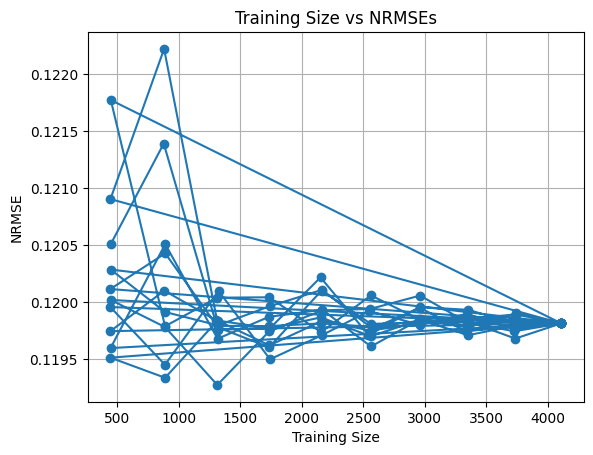

In [26]:
training_sizes = []
nrmses = []

def fn(size):
  matches_train = df.sample(n=size).drop_duplicates()

  # Normalize features
  for feature in features:
      matches_train[feature] = (matches_train[feature] - matches_train[feature].mean()) / matches_train[feature].std()

  # Split the dataset into features (X) and target variable (y)
  X = matches_train.drop([target, "bias"], axis=1).values
  y = matches_train[target].values

  X_transform = sc.fit_transform(X)

  # Initialize parameters: w - weight vector; b - intercept
  theta = np.zeros(2)

  # Initialize parameters: w - weight vector; b - intercept
  w = np.zeros(2)
  b = 0
  iterations = 1000

  # Initialize Hyperparameter (Learning Rate)
  L = 0.01

  theta, b = descend(X_transform, y, theta, b, L, iterations)

  # Normalize features
  for feature in features:
      df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()

  X_test_normalized = df.drop([target, "bias"], axis=1).values
  y_test = df[target].values

  y_pred_test = predict(X_test_normalized, theta, b)
  df_pred = pd.DataFrame()
  df_pred["y_actual_test"] = y_test
  df_pred["y_predicted"] = np.round(y_pred_test, 1)

  accuracy = evaluate_model_accuracy(df_pred, 'y_actual_test', 'y_predicted')
  training_sizes.append(matches_train.shape[0])
  nrmses.append(accuracy)

# Re-train and re-Predict the same data set 10 times with different randomly selected and increasing training set
for j in range(10):
  for i in range(10):
    fn(int(len(df) * (i + 1) * 0.1))


# Plotting the data
plt.plot(training_sizes, nrmses, marker='o')
plt.title('Training Size vs NRMSEs')
plt.xlabel('Training Size')
plt.ylabel('NRMSE')
plt.grid(True)
plt.show()